In [1]:
from gravpop_pipe import *
filename = '/Users/asadh/Documents/Data/event_data2.h5'
selection_filename = '/Users/asadh/Documents/Data/selection_function2.h5'

I = InferenceStandard.from_file(
					event_data_filename = filename,
					selection_data_filename = selection_filename,
					models = []
					)

In [2]:
import jax.numpy as jnp
import jax
from jax import jit

#def box(x,a,b):
#    return jnp.heaviside(x-a, 0.5)*jnp.heaviside(b-x, 0.5)

@jit
def box(x,a,b):
    return jnp.where(x >= a, jnp.where(x <= b, jnp.ones_like(x), jnp.zeros_like(x)), jnp.zeros_like(x))

@jit
def powerlaw(x, alpha, high, low):
    norm = jnp.where(
        jnp.array(alpha) == -1,
        1 / jnp.log(high / low),
        (1 + alpha) / jnp.array(high ** (1 + alpha) - low ** (1 + alpha)),
    )
    prob = jnp.power(x, alpha)*norm*box(x, low, high)
    return prob

@jit
def truncnorm(x, mu, sigma, high, low):
    norm = 2**0.5 / jnp.pi**0.5 / sigma
    norm /= jax.scipy.special.erf((high - mu) / 2**0.5 / sigma) + jax.scipy.special.erf(
        (mu - low) / 2**0.5 / sigma
    )
    prob = jnp.exp(-jnp.power(x - mu, 2) / (2 * sigma**2))
    prob *= norm*box(x, low, high)
    return prob

In [186]:
def _smoothing(masses, mmin, mmax, delta_m):
    shifted_mass = jnp.nan_to_num((masses - mmin) / delta_m, nan=0)
    shifted_mass = jnp.clip(shifted_mass, 1e-6, 1 - 1e-6)
    exponent = 1 / shifted_mass - 1 / (1 - shifted_mass)
    window = jax.scipy.special.expit(-exponent)
    return window#*box(masses, mmin, mmax)

def smoothing(masses, mmin, mmax, delta_m):
    return jnp.where(delta_m > 0.0,  _smoothing(masses, mmin, mmax, delta_m), jnp.ones_like(masses))

def two_component_single(mass, alpha, lam, mmin, mmax, mpp, sigpp, gaussian_mass_maximum=100):
    p_pow = powerlaw(mass, alpha=-alpha, high=mmax, low=mmin)
    p_norm = truncnorm(mass, mu=mpp, sigma=sigpp, high=gaussian_mass_maximum, low=mmin)
    prob = (1 - lam) * p_pow + lam * p_norm
    return prob

class SmoothedTwoComponentPrimaryMassRatio:
    def __init__(self, gaussian_mass_maximum=100, mmin_fixed=2, mmax_fixed=100, primary_mass_name="mass_1", mass_ratio_name="mass_ratio", normalization_shape=(1000,500)):
        self.gaussian_mass_maximum = gaussian_mass_maximum
        self.mmin_fixed = 2
        self.mmax_fixed = 100
        self.primary_mass_name = primary_mass_name
        self.mass_ratio_name = mass_ratio_name
        self.m1s = jnp.linspace(mmin_fixed, mmax_fixed, normalization_shape[0])
        self.qs = jnp.linspace(0, 1, normalization_shape[1])
        self.m1s_grid, self.qs_grid = jnp.meshgrid(self.m1s, self.qs)
        #print("""Note: SmoothedTwoComponentPrimaryMassRatio is an unnormalized distribution. 
        #    Be wary when using these for infering merger rates. 
        #    In addition, this model might have a different primary mass marginal due to this lack of normalization in q""")

    def norm_p_q(self, data, beta, mmin, delta_m):
        """Calculate the mass ratio normalisation by linear interpolation"""
        p_q = powerlaw(self.qs_grid, beta, 1, mmin / self.m1s_grid)
        p_q *= smoothing(
            self.m1s_grid * self.qs_grid, mmin=mmin, mmax=self.m1s_grid, delta_m=delta_m
        )
        norms = jnp.where(
            jnp.array(delta_m) > 0,
            jax.scipy.integrate.trapezoid(jnp.nan_to_num(p_q), self.qs, axis=0),
            jnp.ones(self.m1s.shape),
        )

        result = jnp.interp(data[self.primary_mass_name], self.m1s, norms)
        #result = jnp.interp(data['mass_1'], m1s, norms)
        return jnp.clip(result, 1e-16)  # For preventing 1/0 at masses that are 0

    def norm_p_m1(self, delta_m, **kwargs):
        """Calculate the normalisation factor for the primary mass"""
        mmin = kwargs.get("mmin", self.mmin)
        p_m = self.__class__.primary_model(self.m1s, **kwargs)
        p_m *= smoothing(self.m1s, mmin=mmin, mmax=self.mmax, delta_m=delta_m)

        norm = jnp.where(jnp.array(delta_m) > 0, jax.scipy.integrate.trapezoid(jnp.nan_to_num(p_m), self.m1s), 1)
        return norm

    def __call__(self, data, params):
        # Get params
        alpha = params['alpha']
        lam = params['lam']
        mmin = params.get('mmin', self.mmin_fixed)
        mmax = params.get('mmax', self.mmax_fixed)
        beta = params['beta']
        mpp = params['mpp']
        sigpp = params['sigpp']
        delta_m = params.get("delta_m", 0)

        # Compute primary mass unnormalized distribution with smoothing
        m1 = data[self.primary_mass_name]
        p_m1 = two_component_single(data[self.primary_mass_name],  alpha, lam, mmin, mmax, mpp, sigpp, gaussian_mass_maximum=self.gaussian_mass_maximum)
        p_m1 *= smoothing(data[self.primary_mass_name], mmin, mmax, delta_m)

        p_m1_grid = two_component_single(self.m1s, alpha, lam, mmin, mmax, mpp, sigpp, gaussian_mass_maximum=self.gaussian_mass_maximum)
        p_m1_grid *= smoothing(self.m1s, mmin, mmax, delta_m)
        norm = jnp.where(delta_m > 0, jax.scipy.integrate.trapezoid(jnp.nan_to_num(p_m1_grid), self.m1s), 1)
        p_m1 /= norm

        # Compute mass_ratio unnormalized distribution with smoothing
        p_q = powerlaw(data[self.mass_ratio_name], beta, 1, mmin / data[self.primary_mass_name])
        p_q *= smoothing(
            data[self.primary_mass_name] * data[self.mass_ratio_name],
            mmin=mmin,
            mmax=data[self.primary_mass_name],
            delta_m=delta_m,
        )
        #p_q /= self.norm_p_q(data=data, beta=beta, mmin=mmin, delta_m=delta_m)

        return jnp.nan_to_num(p_m1 * p_q, nan=0)


In [187]:
SM = SmoothedTwoComponentPrimaryMassRatio(primary_mass_name='mass_1')

In [188]:
I.event_data['mass_1'] = I.event_data['mass_1_source']
I.selection_data['mass_1'] = I.selection_data['mass_1_source']

In [189]:
def make_dictionary(x):
    d = {'alpha': x[0], 'beta': x[1], 'mmin': x[2], 'mmax': x[3], 'mpp': x[4], 
         'sigpp': x[5], 'lam': x[6], 'delta_m': x[7], 'lamb':x[8]}
    return d

columns = ['alpha','beta','mmin','mmax','mpp','sigpp','lam','delta_m','lamb']
def make_vector(d):
    return jnp.array([d[col] for col in columns])

check_at = {'mass_1': 50.0, 'mass_ratio': 0.9}
Lambda_0 =  {'alpha': 3.5, 'beta': 1.1, 'mmin': 5.0, 'mmax': 90, 
             'mpp': 35, 'sigpp': 3, 'lam': 0.4, 'lamb':2.9, 'delta_m':7.1}

In [190]:
from jax import jacfwd
def model_gradient(model, data, param, canonical_parameter_order=None):
	canonical_parameter_order = canonical_parameter_order or list(param.keys())

	def make_vector(d):
		return jnp.array([d[param] for param in canonical_parameter_order])

	def make_dictionary(x):
		return {parameter : x[i] for i,parameter in enumerate(canonical_parameter_order)}

	dYdx = jacfwd(lambda x: model(data, make_dictionary(x)))(make_vector(param))
	if len(canonical_parameter_order) == 1:
		return {parameter : dYdx.flatten() for i,parameter in enumerate(canonical_parameter_order)}

	return {parameter : dYdx[..., i] for i,parameter in enumerate(canonical_parameter_order)}



derivatives = model_gradient(SM, I.selection_data, Lambda_0)
print(~np.any(jnp.array([jnp.any(jnp.isnan(derivatives[x])) for x in derivatives.keys()])))

True


In [191]:
test_func = lambda x: smoothing(
            SM.m1s_grid * SM.qs_grid, mmin=x[1], mmax=SM.m1s_grid, delta_m=x[2]
        )

test_func_grad = lambda x: ~jnp.any(jnp.isnan(jax.jacfwd(test_func)(jnp.array(x))))

test_func_grad([2.0, 0.1])

Array(True, dtype=bool)

In [192]:
def norm_p_q(data, beta, mmin, delta_m):
    mmin_fixed = 2.0
    mmax_fixed = 100.0
    m1s = jnp.linspace(mmin_fixed, mmax_fixed, 1000)
    qs = jnp.linspace(0, 1, 500)
    m1s_grid, qs_grid = jnp.meshgrid(m1s, qs)
    p_q = powerlaw(qs_grid, beta, 1, mmin / m1s_grid)
    p_q *= smoothing(
        m1s_grid * qs_grid, mmin=mmin, mmax=m1s_grid, delta_m=delta_m
    )
    norms = jnp.where(
        jnp.array(delta_m) > 0,
        jax.scipy.integrate.trapezoid(jnp.nan_to_num(p_q), qs, axis=0),
        jnp.ones(m1s.shape),
    )

    result = jnp.interp(data['mass_1'], m1s, norms)
    return jnp.clip(result, 1e-16)  # For preventing 1/0 at masses that are 0
    #return norms


norm_p_q({'mass_1':2.01, 'mass_ratio':0.01}, beta=1.1, mmin=3.0, delta_m=6.0)

Array(1.e-16, dtype=float32)

In [204]:
test_point = {'mass_1':2.01, 'mass_ratio':0.01}
test_func = lambda mmin, delta_m: 1/SM.norm_p_q(test_point, beta=1.1, mmin=mmin, delta_m=delta_m)
test_func_vmap = jax.vmap(test_func)
test_func_grad = jax.jacfwd(test_func)
test_func_grad_vmap = jax.vmap(jax.jacfwd(test_func))

test_func_vmap(jnp.array([1.0,2.0,3.0]), jnp.array([6.0, 3.0, 6.0])), test_func_grad_vmap(jnp.array([1.0,2.0, 3.0]), jnp.array([6.0, 3.0, 6.0]))

(Array([6.9174017e+02, 1.8432198e+15, 1.0000000e+16], dtype=float32),
 Array([ 4.8517295e+03,  5.8399660e+17, -0.0000000e+00], dtype=float32))

In [205]:
test_func_2 = lambda x: 1.0/SM.norm_p_q(I.selection_data, beta=1.1, mmin=x[1], delta_m=x[2])
not jnp.any(jnp.isnan(jax.jacfwd(test_func_2)(jnp.array([0.0,2.4]))))

True

In [206]:
jax.grad(lambda ms: smoothing(ms, 2.0, 100.0, 3.0))(1.0)

Array(0., dtype=float32, weak_type=True)

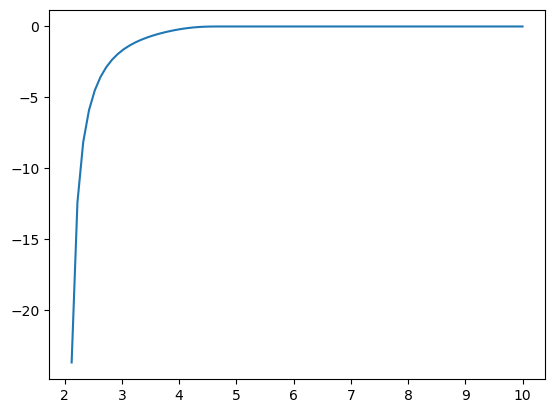

In [207]:
import matplotlib.pyplot as plt
ms = jnp.linspace(0.0, 10.0, 100)
plt.plot(ms, jnp.log(smoothing(ms, 2.0, 100.0, 3.0)))

In [208]:
smoothing(2.9, 3.0, 100.0, 3.0), jax.grad(lambda x : smoothing(x, 3.0, 100.0, 3.0))(2.9), jax.grad(lambda x : jnp.log(smoothing(x, 3.0, 100.0, 3.0)))(2.9)

(Array(0., dtype=float32),
 Array(0., dtype=float32, weak_type=True),
 Array(nan, dtype=float32, weak_type=True))

In [209]:
from jax import jacfwd

Fullderivative = jacfwd(lambda x: jnp.log(SM(I.selection_data, make_dictionary(x))))(make_vector(Lambda_0));

In [210]:
~jnp.any(jnp.isnan(Fullderivative[:,:]))

Array(False, dtype=bool)

In [211]:

value_func = lambda x: jnp.log(SM(check_at, make_dictionary(x)))
test_at = lambda y, check_at: jax.grad(value_func)(y)

test_at(make_vector(Lambda_0), check_at)
#value_func(make_vector(Lambda_0))

Array([-1.7591488e+00,  3.5239342e-01,  4.4697866e-01, -1.4136516e-05,
        3.4727566e-03,  1.6669173e-02, -2.9127207e+00,  3.9422076e-02,
        0.0000000e+00], dtype=float32)

In [212]:
value_func = lambda x: jnp.log(SM(check_at, make_dictionary(x)))
value_func(make_vector(Lambda_0))

Array(-8.064953, dtype=float32)

In [213]:
test_at(make_vector(Lambda_0), check_at)

Array([-1.7591488e+00,  3.5239342e-01,  4.4697866e-01, -1.4136516e-05,
        3.4727566e-03,  1.6669173e-02, -2.9127207e+00,  3.9422076e-02,
        0.0000000e+00], dtype=float32)

In [214]:
jnp.log(SM(check_at, make_dictionary(make_vector(Lambda_0))))

Array(-8.064953, dtype=float32)

In [215]:
make_dictionary(make_vector(Lambda_0))

{'alpha': Array(3.5, dtype=float32),
 'beta': Array(1.1, dtype=float32),
 'mmin': Array(5., dtype=float32),
 'mmax': Array(90., dtype=float32),
 'mpp': Array(35., dtype=float32),
 'sigpp': Array(3., dtype=float32),
 'lam': Array(0.4, dtype=float32),
 'delta_m': Array(7.1, dtype=float32),
 'lamb': Array(2.9, dtype=float32)}

In [216]:
jax.grad(lambda mmin: smoothing(6.0, mmin, 100.0, 0.01))(0.0)

Array(-0., dtype=float32, weak_type=True)

In [217]:
smoothing(6.0, 5.0, 100.0, 0.01)

Array(1., dtype=float32)

In [218]:
from numpyro.distributions import Distribution
import numpyro.distributions as dist

In [248]:
type(jax.random.key(1))

jax._src.prng.PRNGKeyArray

In [223]:
### Test Data
from dataclasses import dataclass
import numpyro.distributions as dist
from numpyro.distributions import Distribution
import jax
import jax.numpy as jnp

from typing import Dict, List

@dataclass
class PriorDictionary:
	priors : Dict[str, Distribution]
	seed : int

	def sample(seed=None):
		seed = seed or seed
		key = jax.random.key(seed)
		point = {}
		for variable, prior_distribution in priors.items():
			point[variable] = prior_distribution.sample(key)

		return point

class Dirac(dist.Distribution):
    arg_constraints = {}
    support = dist.constraints.real
    has_enumerate_support = False

    def __init__(self, value):
        super(Dirac, self).__init__(event_shape=(1,))
        value = value

    def sample(self, key, sample_shape=()):
        return jnp.full(sample_shape + event_shape, value)

    def log_prob(self, value):
        return jnp.where(value == value, 0., -jnp.inf)

@dataclass
class Grid1D:
	name : str = 'x'
	minimum : float = 0.0
	maximum : float = 0.0
	N : int = 100
	latex_name : str = r'$x$'

	def __post_init__(self):
		if name != 'x':
			latex_name = fr'${name}$'

		grid = jnp.linspace(minimum, maximum, N)
		_data = {name : grid}

	@property
	def data(self):
		return _data
	

@dataclass
class Grid:
	grid_list : List[Grid1D]

	def __post_init__(self):
		grid_1ds = {g.name : g.grid for g in grid_list}
		grid_combos = jnp.meshgrid(*[g.grid for g in grid_list])
		data = {}
		for i,g in enumerate(grid_list):
			data[g.name] = grid_combos[i]
		_data = data

	@property
	def data(self):
		return _data


mass_grid = Grid([Grid1D(name='mass_1', minimum=2, maximum=100, N=200), 
				  Grid1D(name='mass_ratio', 	 minimum=0, maximum=1  , N=200)])

redshift_grid = Grid1D(name='redshift', minimum=0, maximum=3, N=200)

NameError: name 'name' is not defined

In [219]:
import gwpopulation

Mgravpop = SM = SmoothedTwoComponentPrimaryMassRatio(primary_mass_name='mass_1')
Mgwpop = gwpopulation.models.mass.SinglePeakSmoothedMassDistribution()

mass_params = {k:v for k,v in Lambda_0.items() if k != 'lamb'}

In [220]:
SM({'mass_1': 20, 'mass_ratio':1.0},mass_params)

Array(0.00913109, dtype=float32)

In [221]:
plt.hist(jnp.abs(Z_grav/Z_gw).flatten(), bins=100);

NameError: name 'Z_grav' is not defined

In [222]:
Z_grav = SM(mass_grid.data, mass_params)
Z_gw = Mgwpop(mass_grid.data, **mass_params)

import matplotlib.pyplot as plt
M1, Q = mass_grid.data['mass_1'], mass_grid.data['mass_ratio']
plt.contourf(M1, Q, jnp.abs(Z_grav/Z_gw), vmax=1.0)
plt.colorbar()

NameError: name 'mass_grid' is not defined

In [70]:
ind = jnp.argwhere(jnp.abs(Z_grav-Z_gw) > 1.0)
mass_grid.data['mass_1'][199,3]
mass_grid.data['mass_ratio'][199,3]

Array(1., dtype=float32)

In [334]:
dYdX = jacfwd(lambda x: SM(mass_grid.data, make_dictionary(x)))(make_vector(Lambda_0));

In [446]:
def test_model_gradient(model, data, param, canonical_parameter_order=None):
	canonical_parameter_order = canonical_parameter_order or list(param.keys())

	def make_vector(d):
		return jnp.array([d[param] for param in canonical_parameter_order])

	def make_dictionary(x):
		return {parameter : x[i] for i,parameter in enumerate(canonical_parameter_order)}

	dYdx = jacfwd(lambda x: model(data, make_dictionary(x)))(make_vector(param))
	if len(canonical_parameter_order) == 1:
		return {parameter : dYdx.flatten() for i,parameter in enumerate(canonical_parameter_order)}

	return {parameter : dYdx[..., i] for i,parameter in enumerate(canonical_parameter_order)}


In [357]:
R = PowerLawRedshift(z_max=3.0)

In [449]:
der = test_model_gradient(R, redshift_grid.data, {'lamb' : 0.5})
der

{'lamb': Array([ 0.        , -0.00033175, -0.00127821, -0.00277073, -0.00474544,
        -0.00714297, -0.00990819, -0.01298999, -0.01634105, -0.01991761,
        -0.02367931, -0.02758895, -0.03161233, -0.03571809, -0.03987749,
        -0.04406434, -0.04825474, -0.05242704, -0.0565616 , -0.06064077,
        -0.0646487 , -0.06857114, -0.07239556, -0.07611077, -0.07970703,
        -0.08317583, -0.08650988, -0.08970288, -0.09274967, -0.09564595,
        -0.09838824, -0.10097394, -0.10340111, -0.10566849, -0.10777547,
        -0.10972187, -0.11150811, -0.11313508, -0.11460399, -0.11591645,
        -0.11707447, -0.11808028, -0.11893634, -0.11964539, -0.12021039,
        -0.1206344 , -0.1209207 , -0.12107262, -0.12109371, -0.12098745,
        -0.12075752, -0.12040754, -0.11994131, -0.11936246, -0.11867488,
        -0.11788224, -0.11698825, -0.11599668, -0.11491121, -0.11373544,
        -0.11247304, -0.11112761, -0.10970253, -0.10820135, -0.1066275 ,
        -0.10498423, -0.10327487, -0.101502

In [447]:
R(redshift_grid.data, {'lamb' : 0.5});

In [369]:
list(Lambda_0.keys())

['alpha', 'beta', 'mmin', 'mmax', 'mpp', 'sigpp', 'lam', 'lamb', 'delta_m']

In [417]:
der = test_model_gradient(SM, mass_grid.data, Lambda_0)

In [418]:
#der

In [419]:
bb = ['alpha','beta','mmin','mmax','mpp','sigpp','lam','delta_m']
param = {a:Lambda_0[a] for a in bb}

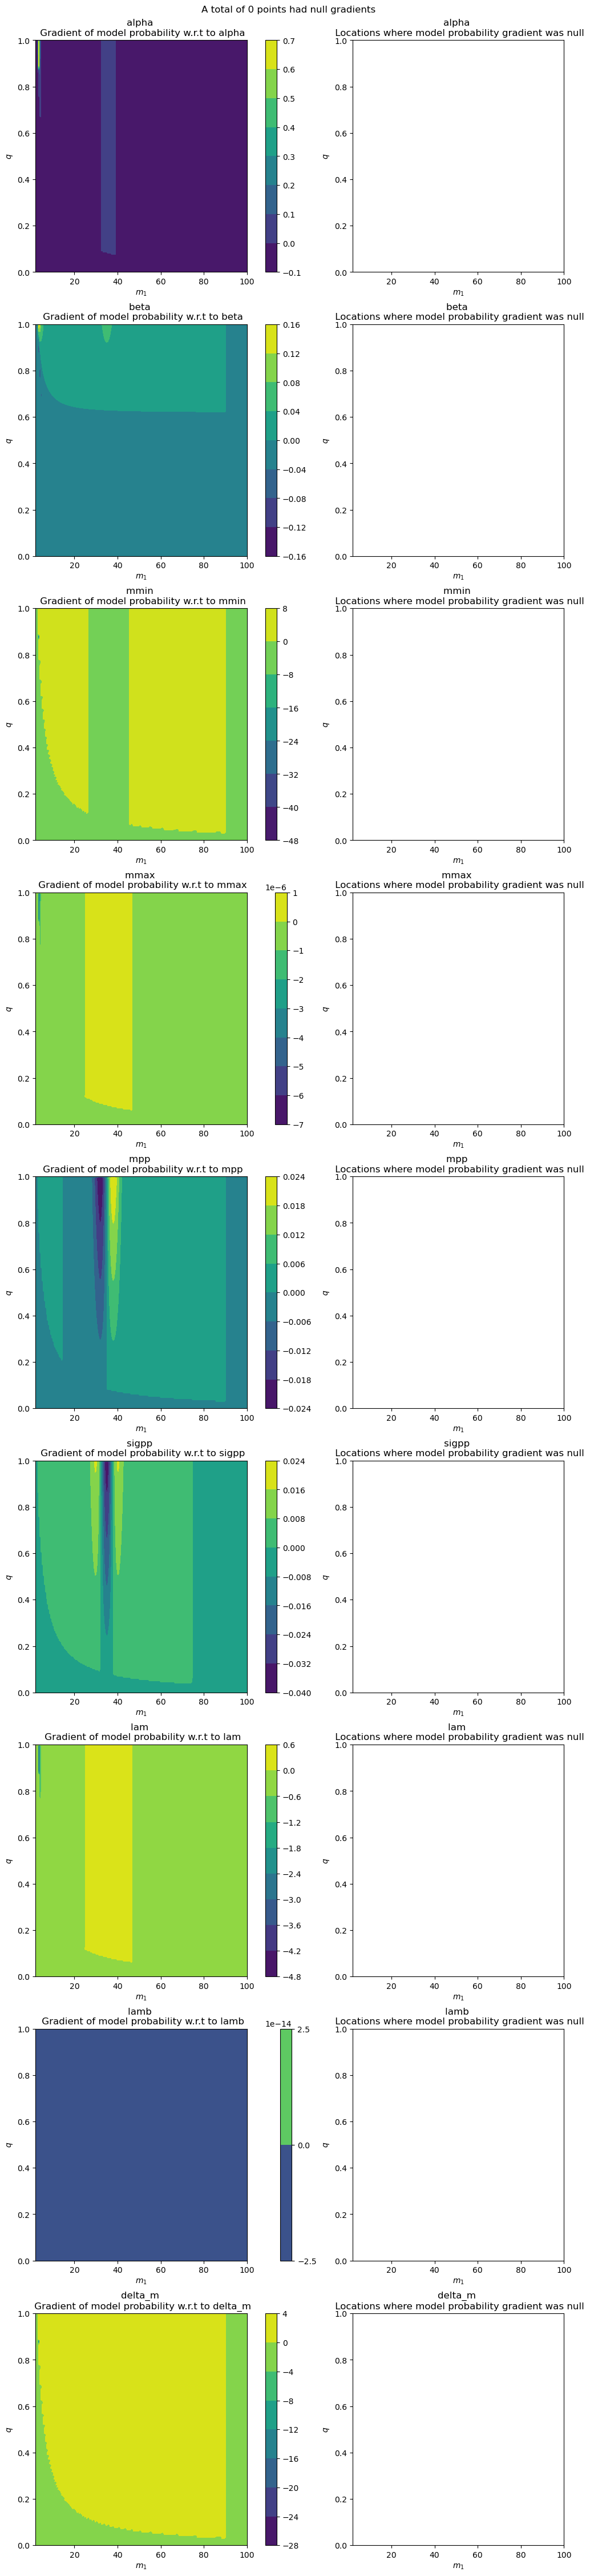

In [445]:
Z_gravpop = SM(mass_grid.data, param)



import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


keys = list(der.keys())
n = len(keys)
fig = plt.figure(layout="constrained", figsize=(10, 5*n))
gs = GridSpec(n, 2, figure=fig)

axes = []
for i in range(n):
    row_axes = []
    for j in range(2):
        ax = fig.add_subplot(gs[i, j])
        row_axes.append(ax)
    axes.append(row_axes)

for i, ax_row in enumerate(axes):
    ax = ax_row[0]
    M1, Q = mass_grid.data["mass_1_source"], mass_grid.data["mass_ratio"]
    contour = ax.contourf(M1,Q,der[keys[i]])
    cbar = plt.colorbar(contour, ax=ax)
        
    # Add axis labels and title
    ax.set_xlabel(r"$m_1$")
    ax.set_ylabel(r"$q$")
    ax.set_title(f"{keys[i]} \n Gradient of model probability w.r.t to {keys[i]}")
    
    ax = ax_row[1]
    null_values_mask = jnp.isnan(der[keys[i]])
    ax.imshow(null_values_mask, extent=(M1.min(), M1.max(),
                                         Q.min(), Q.max()),
              cmap='binary', alpha=0.5, origin='lower', aspect='auto')
    
   #ax.set_aspect('equal')
        
    # Add axis labels and title
    ax.set_xlabel(r"$m_1$")
    ax.set_ylabel(r"$q$")
    ax.set_title(f"{keys[i]} \n Locations where model probability gradient was null")
    
    
total_null_points = jnp.sum(jnp.array([jnp.sum(jnp.isnan(value)) for value in der.values()]))
plt.suptitle(f"A total of {total_null_points} points had null gradients")
plt.show()

In [406]:
gs.ncols

2

In [410]:
axes[0]

<Axes: >

In [224]:
import pandas as pd

In [251]:
path = "/Users/asadh/Documents/GitHub/gravpop_pipe/dev/samples_output.csv"

df = pd.read_csv(path)

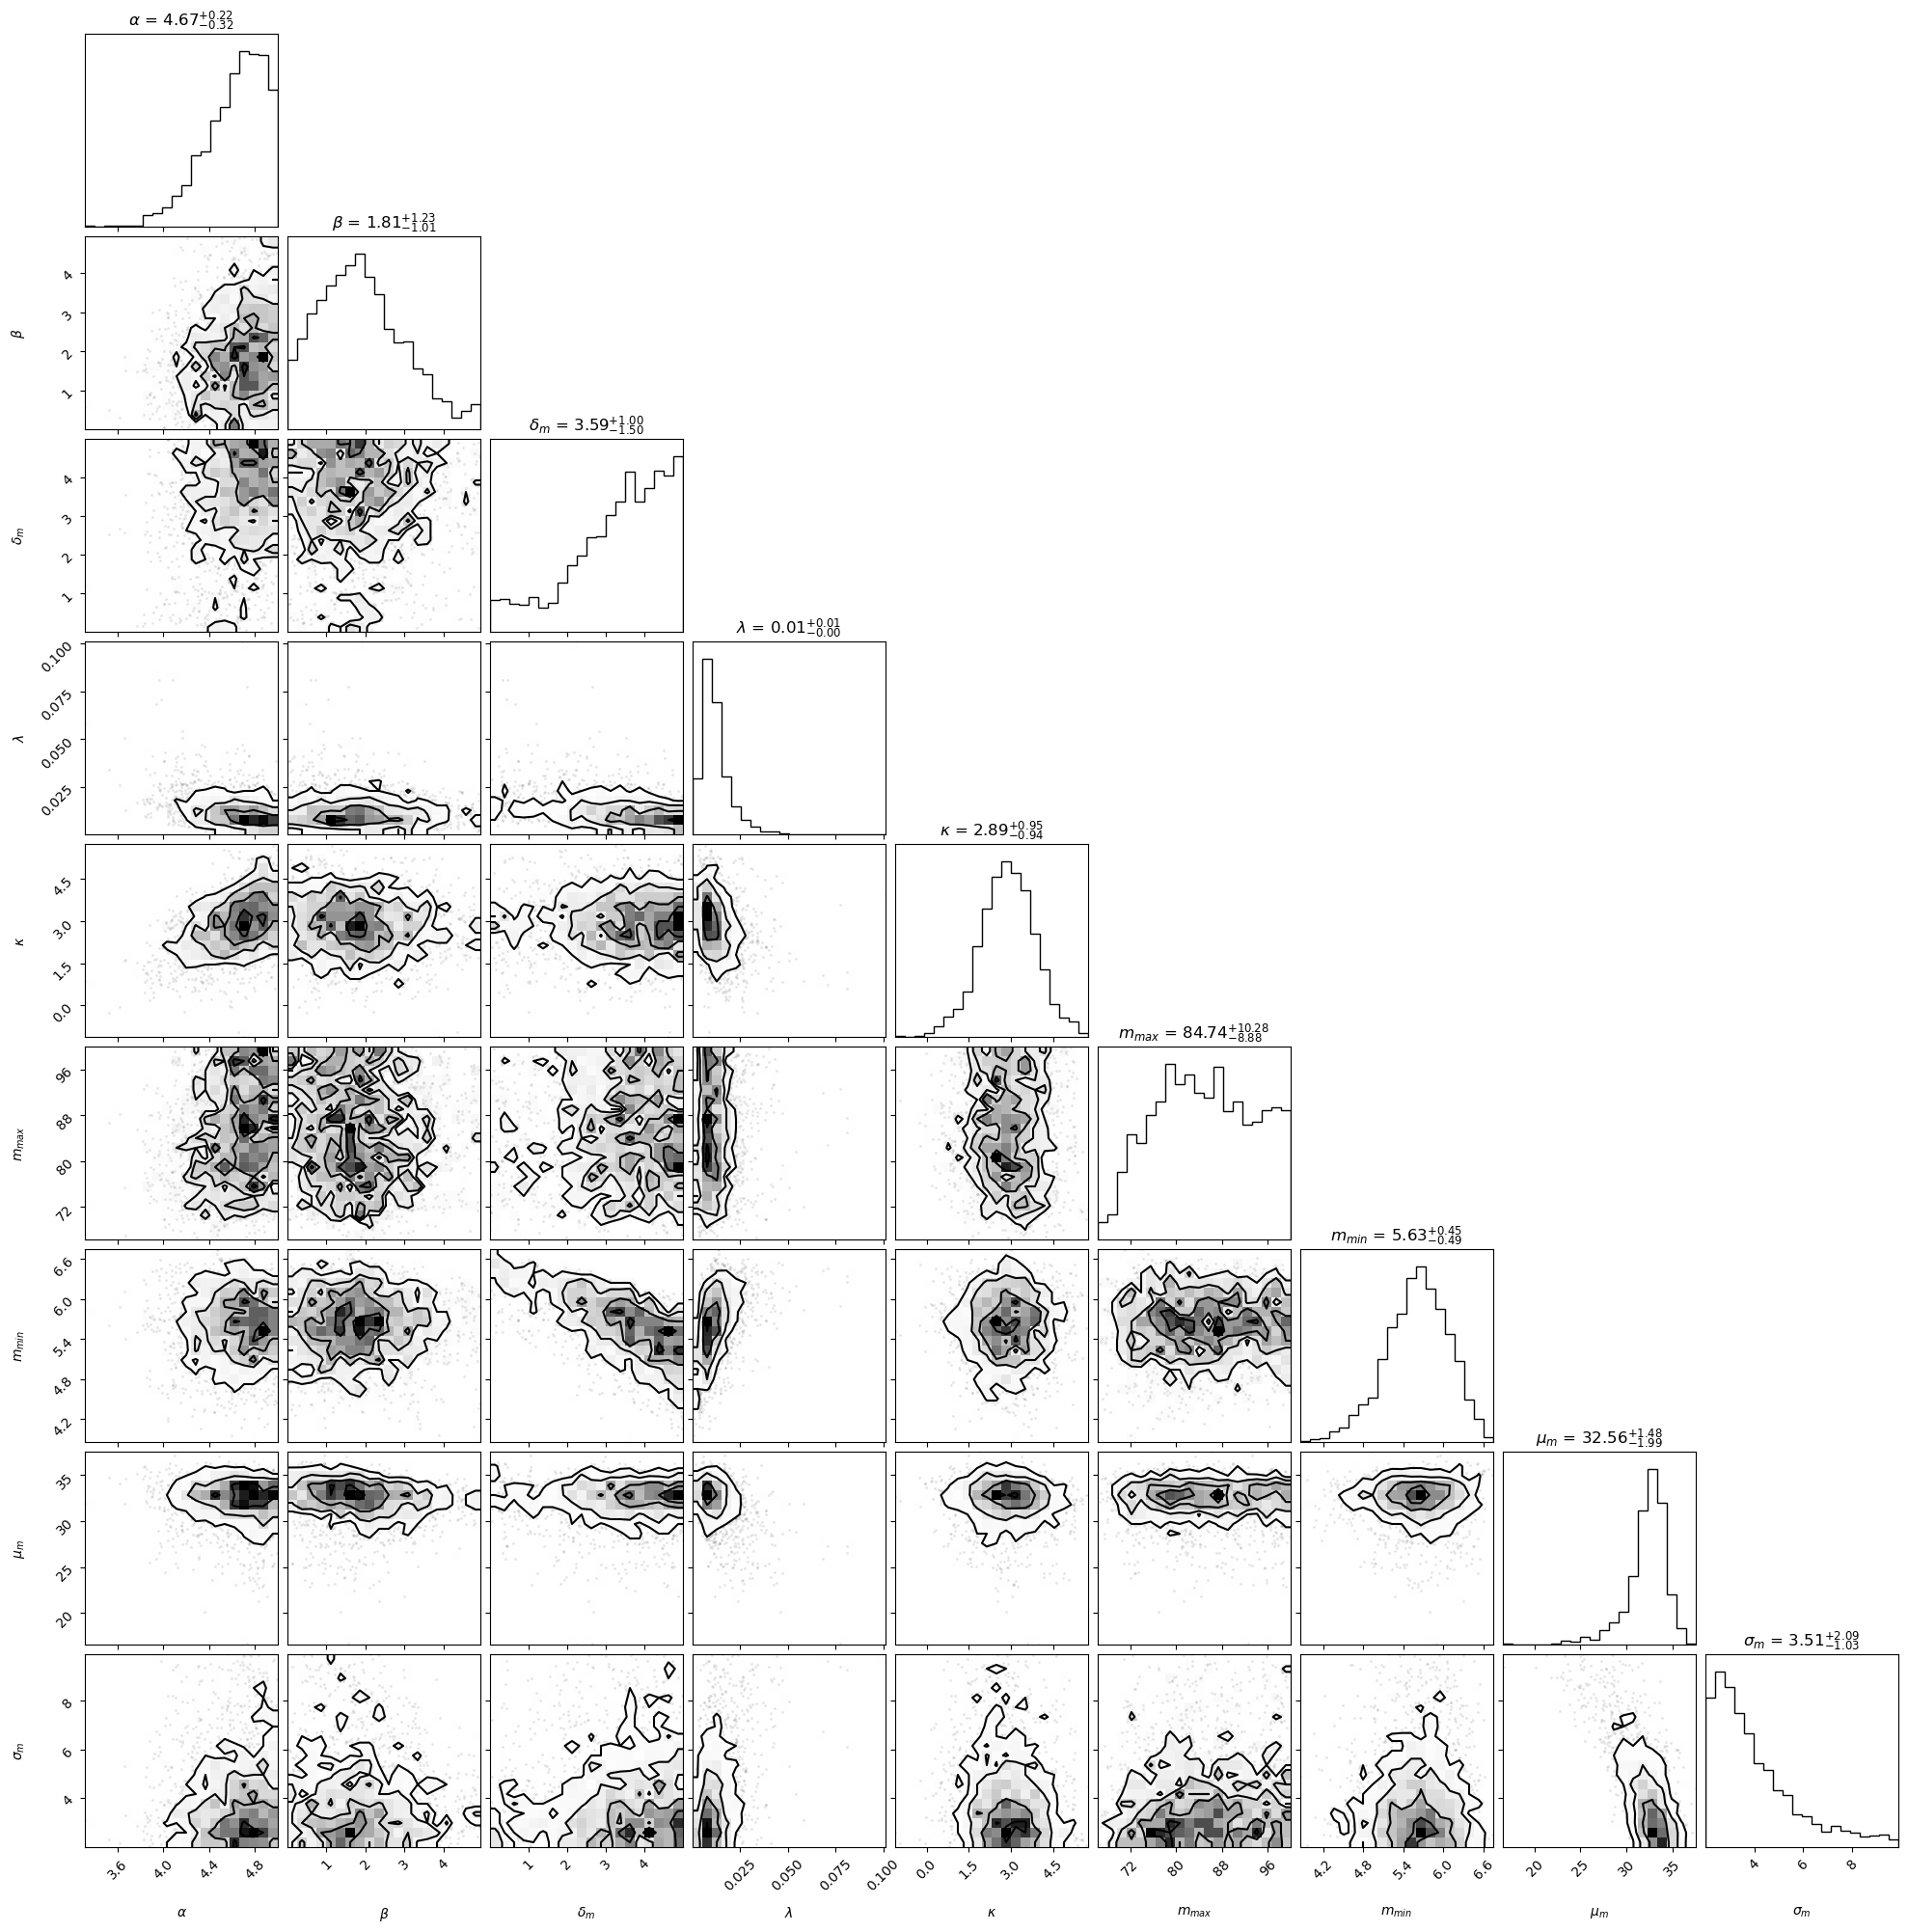

In [254]:
columns = [col for col in df.columns if "Unnamed" not in col]
import corner

corner.corner(df[columns].values,labels=df[columns].columns, show_titles=True);

In [248]:
df[((df[columns[0]] - df[columns[0]].shift(1)) == 0)]

,Unnamed: 0,$\alpha$,$\beta$,$\delta_m$,$\lambda$,$\kappa$,$m_{max}$,$m_{min}$,$\mu_{m}$,$\sigma_{m}$
30,30,4.607992,2.001711,0.242661,0.018107,2.66708,89.21678,6.339042,31.14634,2.439177


In [257]:
import posterir

{'chi_1': Array([0.38959044, 0.2121195 , 0.25252587, ..., 0.90750337, 0.43650082,
        0.6912355 ], dtype=float32),
 'chi_2': Array([0.6443355 , 0.5891269 , 0.77107537, ..., 0.28053418, 0.14287075,
        0.5883661 ], dtype=float32),
 'mass_1_source': Array([67.47129  , 22.834873 ,  2.0006313, ..., 11.219816 , 44.942635 ,
        52.276466 ], dtype=float32),
 'mass_ratio': Array([0.8689939 , 0.8625894 , 0.99976236, ..., 0.83509886, 0.88973236,
        0.7145597 ], dtype=float32),
 'prior': Array([8.1498072e-08, 2.5253707e-06, 1.7653511e-01, ..., 6.4839269e-06,
        2.0578009e-05, 1.2208021e-07], dtype=float32),
 'redshift': Array([0.3759587 , 0.1503566 , 0.02307485, ..., 0.1498205 , 1.1509213 ,
        0.6136328 ], dtype=float32),
 'mass_1': Array([67.47129  , 22.834873 ,  2.0006313, ..., 11.219816 , 44.942635 ,
        52.276466 ], dtype=float32)}